# Meat Net: TVC and quality estimator

The aim of this notebook is to develop a neural network to estimate the TVC of a beef cut from the outputs of a electronic nose (e-nose) of 11 Metal-Oxide-Semiconductor (MOS) Volatile Organic  Compounds (VOCs) sensors. Additionally, the a discrete class will be associated to the e-nose read that will refer to the beef cut quality depending on the range of the TVC. The dataset that is used in this notebook is available [here](https://ieee-dataport.org/documents/dataset-electronic-nose-various-beef-cuts).

Table of contents:
  
- [Dataset](#dataset):
    - [Loading the data](#loading-the-data)
    - [Preprocess](#preprocess)
    - [Dataset splits](#dataset-splits)
- [Neural Network](#neural-network)
    - [Architecture](#architecture)
    - [Learning process](#learning-process)
    - [Classification performance](#classification-performance)
- [Model evaluation](#model-evaluation)
    - [Regression model](#regression-model)
    - [Classification performance](#classification-performance)

The following cell include the dependencies, double check you have them installed.


In [1]:
from openpyxl import load_workbook
import matplotlib.pyplot as plt
import matplotlib.font_manager
import numpy as np
from parse import *
from os import mkdir, listdir, system, rename
from shutil import rmtree, copytree
from scipy.signal import savgol_filter
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import display, clear_output
import time
from sklearn.utils import shuffle
import sklearn.metrics as metrics

As the results must be reproducible, the torch's random generator seed's is fixed.

In [2]:
torch.manual_seed(0);
torch.cuda.manual_seed(0)

The number of threads is also set to be the number of CPU cores to optimize the training process, in our case 8.

In [3]:
torch.set_num_threads(8)

If a CUDA-enabled GPU is available, it is set to be the device to run the network

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Dataset

## Loading the data

The first thing to do is to load the data, that in this case is stored in an Excel workbook. The following cells download the data (if it is not present in the directory) and load them to `numpy` arrays.

In [5]:
if not 'e-nose_dataset_12_beef_cuts.xlsx' in listdir():
    system('curl -O https://dedyrw.staff.telkomuniversity.ac.id/files/2018/09/e-nose_dataset_12_beef_cuts.xlsx')

In [6]:
wb = load_workbook('e-nose_dataset_12_beef_cuts.xlsx', data_only=True)
cuts = wb.sheetnames

In [7]:
t = np.empty([2220, len(cuts)])
TVC = np.empty([2220, len(cuts)])
label = np.empty([2220, len(cuts)])
sens_temp = np.empty([2220, 11, len(cuts)])
cut_names = []

In [8]:
for cut in cuts:
    cut_number = int(parse('{}.{}', cut)[0])-1
    cut_names.append(parse('{}.{}', cut)[1])
    
    sheet = wb[cut]
    
    for row in range(2,2222):
        t[row-2, cut_number] = sheet['A{}'.format(row)].value
        TVC[row-2, cut_number] = sheet['B{}'.format(row)].value
        label[row-2, cut_number] = sheet['C{}'.format(row)].value
        for letter in [chr(i) for i in range(ord('D'),ord('O'))]:
            sens_temp[row-2, ord(letter)-ord('D'), cut_number] = sheet['{}{}'.format(letter,row)].value

In [9]:
for i, cut in enumerate(cut_names):
    cut_names[i] = cut.replace('_', ' ')

In [10]:
sens_names = []
for letter in [chr(i) for i in range(ord('D'),ord('O'))]:
    sens_names.append(sheet['{}1'.format(letter)].value)

In [11]:
del(wb)

The directories to save the plots, models and results are created in the next cell.

In [12]:
for i, cut in enumerate(cut_names):
    try:
        mkdir('./{}'.format(cut))
    except(FileExistsError):
        pass

Let's take a look to the dataset plotting the TVC, the label and the senor outputs for each cut. 

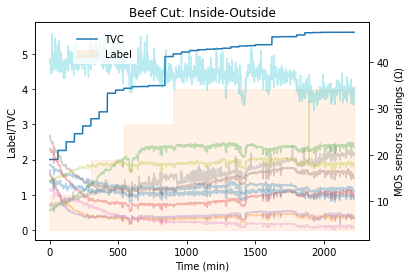

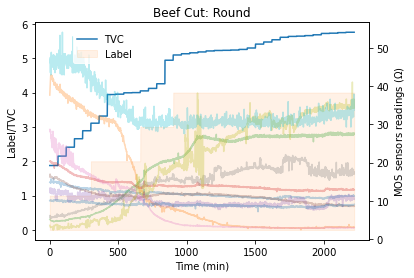

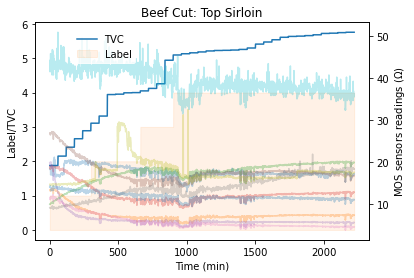

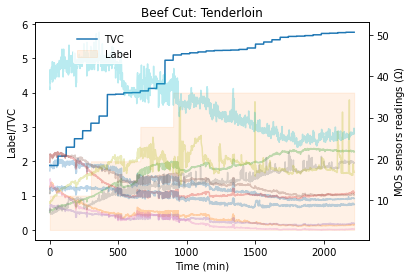

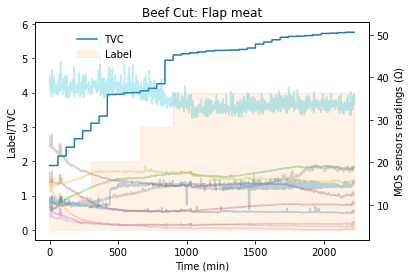

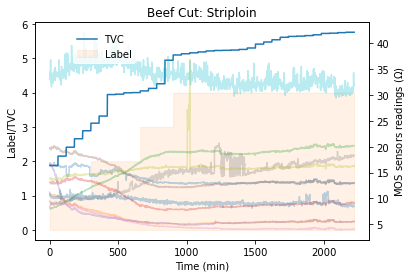

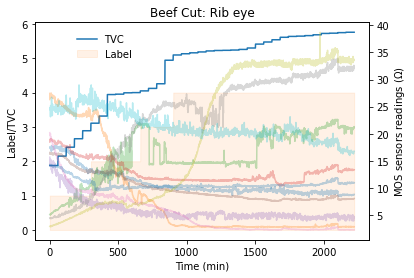

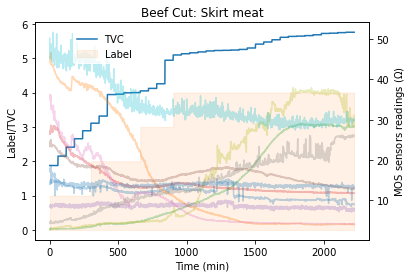

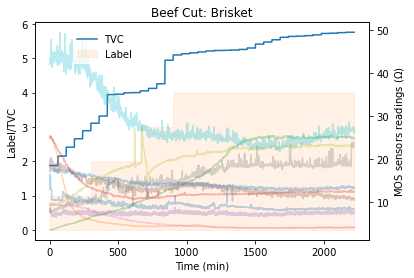

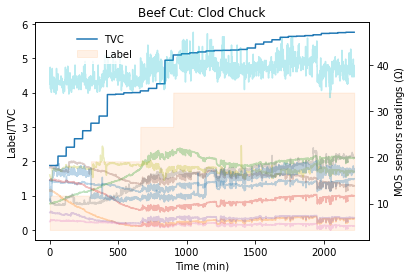

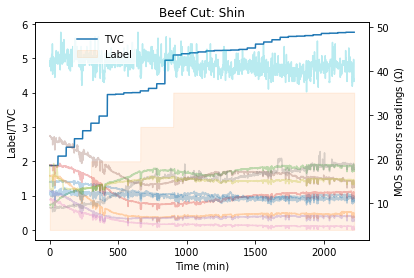

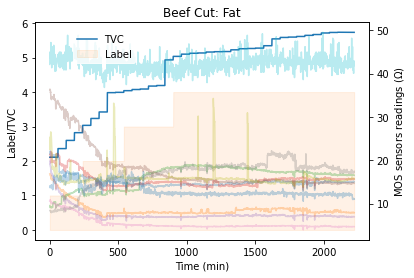

In [13]:
for i, cut in enumerate(cut_names):

    fig, ax2= plt.subplots()

    ax1 = ax2.twinx()

    ax2.set_ylabel('Label/TVC') 
    ax2.fill_between(t[:, i], label[:, i], color='C1', alpha=0.1, label='Label')
    ax2.plot(t[:,i], TVC[:,i], label='TVC')

    ax2.set_xlabel('Time (min)')
    ax1.set_ylabel('MOS sensors readings ($\Omega$)')
    for j in range(len(sens_names)):
        ax1.plot(t[:,i], sens_temp[:, j, i], alpha=0.3)
    fig.legend(bbox_to_anchor=[0.37,0.87], frameon=True, framealpha=0.8, facecolor='w', edgecolor='w')

    plt.title('Beef Cut: {}'.format(cut))
    
    plt.savefig('./{}/raw-data.svg'.format(cut))
    plt.savefig('./{}/raw-data.png'.format(cut), dpi=600)

## Preprocess

As you may noticed, the sensor readings have a lot of inconsistencies. In order to mitigate them a [Savitzky–Golay](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) filter is applied to each sensor in each cut.

In [14]:
sens_smooth = np.empty_like(sens_temp)
for i in range(len(cut_names)):
    for j in range(len(sens_names)):
        sens_smooth[:,j,i] = savgol_filter(sens_temp[:,j,i], 15, 5)

There is another preprocess step we want to take: the normalization. Since the target of the entire project is to implement the neural network resulting in this notebook into a FPGA using fixed-point data types, it is of interest to have the inputs (MOS sensor readings), the models' parameters, the internal values and the output in a constrained range. One thing that can help to this is to normalize the data. Also this will impact to the learning process, since it is [shown](https://towardsdatascience.com/why-data-should-be-normalized-before-training-a-neural-network-c626b7f66c7d) that it generally speeds up the training.

Note that the normalization method used here is

$
    \bar{x} = \frac{x - x_{\min{}}}{x_{\max{}} - x_{\min{}}} \quad ,
$

where $\bar{x}$ is the normalized version of $x$.

In [15]:
TVC_max = TVC.max()
TVC_min = TVC.min()
np.save('TVC_min.npy', TVC_min)
np.save('TVC_max.npy', TVC_max)
TVC = (TVC - TVC.min())/(TVC.max() - TVC.min())

In [16]:
for i in range(len(sens_names)):
    sens_smooth[:,i,:] = (sens_smooth[:,i,:]-sens_smooth[:,i,:].min())/(sens_smooth[:,i,:].max()-sens_smooth[:,i,:].min())

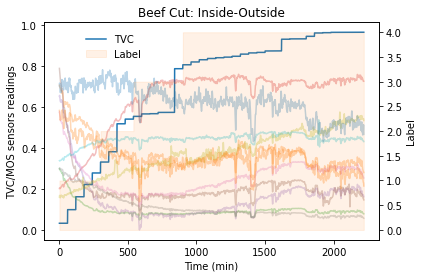

In [17]:
for i, cut in enumerate(cut_names[:1]):

    fig, ax2= plt.subplots()

    ax1 = ax2.twinx()

    ax2.set_ylabel('TVC/MOS sensors readings') 
    ax1.fill_between(t[:, i], label[:, i], color='C1', alpha=0.1, label='Label')
    ax2.plot(t[:,i], TVC[:,i], label='TVC')

    ax2.set_xlabel('Time (min)')
    ax1.set_ylabel('Label')
    for j in range(len(sens_names)):
        ax2.plot(t[:,i], sens_smooth[:, j, i], alpha=0.3)
    fig.legend(bbox_to_anchor=[0.37,0.87], frameon=True, framealpha=0.8, facecolor='w', edgecolor='w')

    plt.title('Beef Cut: {}'.format(cut))
    
    plt.savefig('./{}/preprocessed-data.svg'.format(cut))
    plt.savefig('./{}/preprocessed-data.png'.format(cut))

## Dataset splits

Now its time to split the dataset into the training, validation and test sets. But, in order to get an homogeneous sample for each subset in each cut, it is needed to shuffle the time series of each cut. Then we will be able to create the splits and initialize them as dataloaders.

In [18]:
t.shape, sens_smooth.shape, TVC.shape, label.shape

((2220, 12), (2220, 11, 12), (2220, 12), (2220, 12))

In [19]:
t_rnd = np.empty_like(t)
sens_rnd = np.empty_like(sens_smooth)
TVC_rnd = np.empty_like(TVC)
label_rnd = np.empty_like(label)

for cut in range(len(cut_names)):
    t_rnd[:,i], sens_rnd[:,:,i], TVC_rnd[:,i], label_rnd[:,i] = shuffle(t[:,i], sens_smooth[:,:,i], TVC[:,i], label[:,i], random_state=0)

In [20]:
t_rnd, sens_rnd, TVC_rnd, label_rnd = shuffle(t, sens_smooth, TVC, label, random_state=0)

In [21]:
TS_VS_factor = 0.6
sens_TS, sens_VS = np.split(sens_rnd, [int(TS_VS_factor*sens_rnd.shape[0])])
TVC_TS, TVC_VS = np.split(TVC_rnd, [int(TS_VS_factor*sens_rnd.shape[0])])
label_TS, label_VS = np.split(label_rnd, [int(TS_VS_factor*sens_rnd.shape[0])])
t_TS, t_VS = np.split(t_rnd, [int(TS_VS_factor*sens_rnd.shape[0])])

In [22]:
TestS_CrossVS_factor = 0.5
sens_TestS, sens_CrossVS = np.split(sens_VS, [int(TestS_CrossVS_factor*sens_VS.shape[0])])
TVC_TestS, TVC_CrossVS = np.split(TVC_VS, [int(TestS_CrossVS_factor*sens_VS.shape[0])])
label_TestS, label_CrossVS = np.split(label_VS, [int(TestS_CrossVS_factor*sens_VS.shape[0])])
t_TestS, t_CrossVS = np.split(t_VS, [int(TestS_CrossVS_factor*sens_VS.shape[0])])

To simplify the future plots of the test set when evaluatng the model performance, it is sorted in the next cell.

In [23]:
idx_sorted_TestS = np.argsort(t_TestS[:,0])
sens_TestS = sens_TestS[idx_sorted_TestS,:,:]
TVC_TestS = TVC_TestS[idx_sorted_TestS,:]
label_TestS = label_TestS[idx_sorted_TestS,:]
t_TestS = t_TestS[idx_sorted_TestS,:]

In [24]:
sens_TestS.shape

(444, 11, 12)

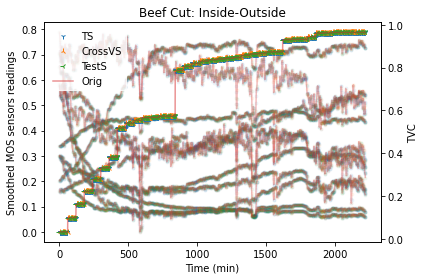

In [25]:
for cut_number in range(1):
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()

    ax2.set_ylabel('TVC') 
    ax2.plot(t_TS[:,cut_number], TVC_TS[:,cut_number], '1C0', label='TS')
    ax2.plot(t_CrossVS[:,cut_number], TVC_CrossVS[:,cut_number], '2C1', label='CrossVS')
    ax2.plot(t_TestS[:,cut_number], TVC_TestS[:,cut_number], '3C2', label='TestS')
    ax2.plot(t[:,cut_number], TVC[:,cut_number], 'C3', alpha=0.5, label='Orig')

    ax1.set_xlabel('Time (min)')
    ax1.set_ylabel('Smoothed MOS sensors readings')
    for i in range(11):
        ax1.plot(t_TS[:,cut_number], sens_TS[:, i, cut_number], '.C0', alpha=.05)
        ax1.plot(t_CrossVS[:,cut_number], sens_CrossVS[:, i, cut_number], '.C1', alpha=.05)
        ax1.plot(t_TestS[:,cut_number], sens_TestS[:, i, cut_number], '.C2', alpha=.05)
        ax1.plot(t[:,cut_number], sens_smooth[:, i, cut_number], 'C3', alpha=0.3)

    ax2.legend(facecolor='w', frameon=True, framealpha=0.8, edgecolor='w')

    plt.title('Beef Cut: {}'.format(cut_names[cut_number]))

    plt.tight_layout()

In [26]:
sens_TS.shape, TVC_TS.shape, sens_CrossVS.shape, TVC_CrossVS.shape, sens_TestS.shape, TVC_TestS.shape

((1332, 11, 12),
 (1332, 12),
 (444, 11, 12),
 (444, 12),
 (444, 11, 12),
 (444, 12))

In [27]:
sens_TS = torch.tensor(sens_TS, dtype=torch.float).to(device)
TVC_TS = torch.tensor(TVC_TS, dtype=torch.float).to(device)

sens_CrossVS = torch.tensor(sens_CrossVS, dtype=torch.float).to(device)
TVC_CrossVS = torch.tensor(TVC_CrossVS, dtype=torch.float).to(device)

In [28]:
bsTS = 1
bsVS = 1

train_ds = []
valid_ds = []
train_dl = []
valid_dl = []

for i in range(len(cut_names)):
    train_ds.append(torch.utils.data.TensorDataset(sens_TS[:,:,i], TVC_TS[:,i]))
    valid_ds.append(torch.utils.data.TensorDataset(sens_CrossVS[:,:,i], TVC_CrossVS[:,i]))

    train_dl.append(torch.utils.data.DataLoader(train_ds[i], batch_size=bsTS, shuffle=True))
    valid_dl.append(torch.utils.data.DataLoader(valid_ds[i], batch_size=bsVS))

Note that the batch size is fixed to one. 

# Neural Network

In this section the neural model architecture is described and the learning process is launched.

## Architecture

The first thing to do with the neural network is to define its architecture. In this case we are using a Multilayer Perceptron (MLP) with two hidden layers of 32 and 12 neurons respectively. Since the network inputs are the MOS sensors readings, 11, and the output is the estimation of the TVC, 1; the resulting architecture is 11-32-12-1. Another thing to choose is the activation function. In this case the [LReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)#Leaky_ReLU) is used, since it solves the [dying ReLU problem](https://medium.com/@shubham.deshmukh705/dying-relu-problem-879cec7a687f).

It's also remarkable to say that 12 models are going to be initialized, since we are developing one model for each cut.

To ensure the reproducibility of the results the weights initialization is fixed, since the random generator seed of torch is fixed at the beginning of the notebook.

In [29]:
def init_weights(m):
    if type(m) == nn.Linear:
        #nn.init.uniform_(m.weight, -0.1, 0.1)
        nn.init.zeros_(m.weight)
        #nn.init.ones_(m.weight)

In [30]:
D_in, H1, H2, D_out = 11, 32, 12, 1

model = []

class TwoHidden(torch.nn.Module):
    
    def __init__(self, D_in, H1, H2, D_out):
        
        super(TwoHidden, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)

    def forward(self, x):
        
        x = self.linear1(x)
        x = F.leaky_relu(x)
        x = self.linear2(x)
        x = F.leaky_relu(x)
        x = self.linear3(x)
        x = F.leaky_relu(x)
        return x

for i in range(12):
    model.append(TwoHidden(D_in, H1, H2, D_out).to(device))
    #model[i].apply(init_weights)

In [31]:
len(model)

12

In [32]:
next(model[0].parameters()).device

device(type='cuda', index=0)

## Learning process

In the next cells the learning process is coded. The training hyperparameters are the epcohs to train and the learning rate. The cost used here is the [Mean Squared Error (MSE)](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html) and the optimizer is [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam).

In [33]:
epochs, learning_rate = 50, 3e-4

'Cut: 12/12 Epoch: 50; Train Loss: 0.00071258, Min Train Loss: 0.00071258; Valid Loss: 0.00069738, Min Valid Loss: 0.00069614'

Training time: 24.234662465254466 min


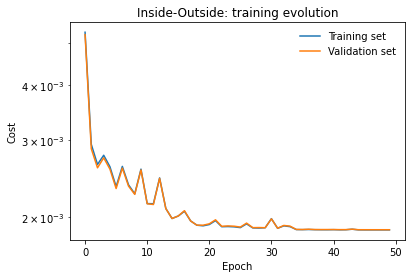

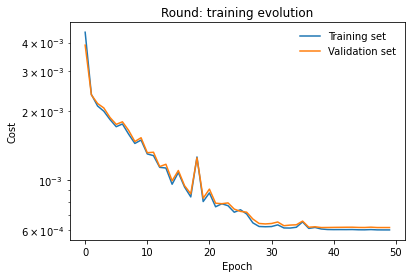

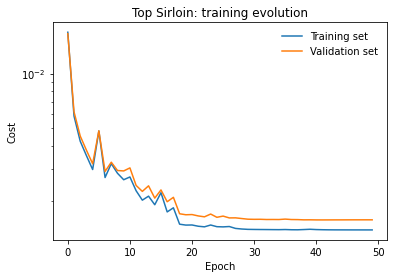

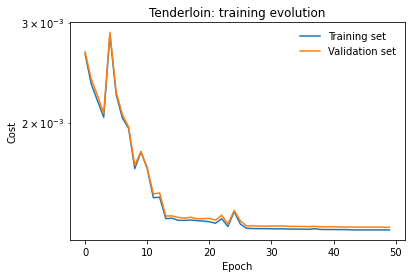

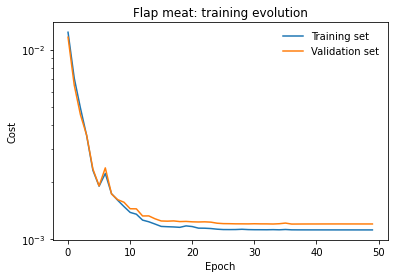

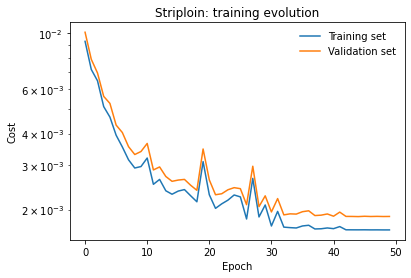

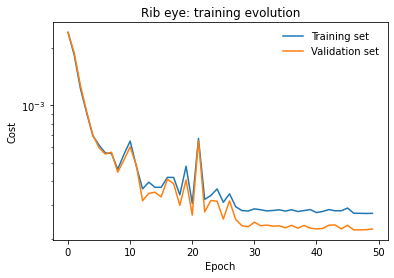

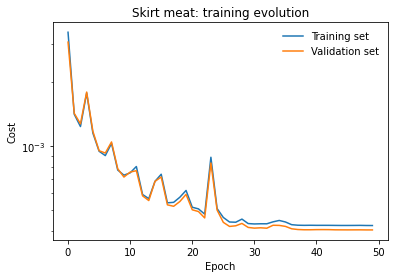

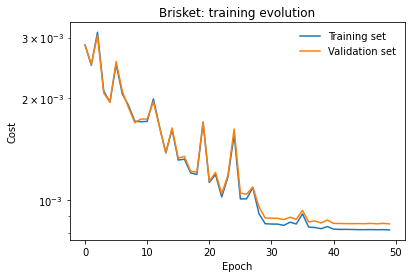

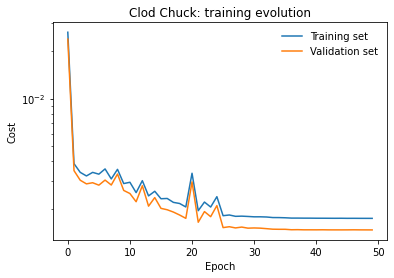

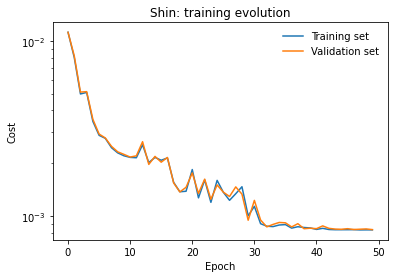

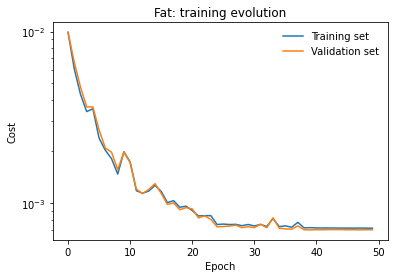

In [35]:
t0 = time.time()

loss_formatter = '{:07.5}'

for i, cut in enumerate(cut_names):
    
    subdir = "tmp"
    
    try:
        mkdir('./{}/{}/'.format(cut, subdir))
    except(FileExistsError):
        rmtree('./{}/{}/'.format(cut, subdir))
        mkdir('./{}/{}/'.format(cut, subdir))
        pass

    criterion = torch.nn.MSELoss(reduction='mean')
    #criterion = torch.nn.CrossEntropyLoss()
    #optimizer = torch.optim.SGD(model[i].parameters(), lr=learning_rate)
    optimizer = torch.optim.Adam(model[i].parameters(), lr=learning_rate)
    schuelder = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

    train_loss_data = 100*torch.ones(epochs, device=device)
    train_dl_len = torch.tensor(len(train_dl[i]), device=device)
    valid_loss_data = 100*torch.ones(epochs, device=device)
    valid_dl_len = torch.tensor(len(valid_dl[i]), device=device)
    #valid_loss = 1
    epoch = 0
    #while valid_loss > 1e-3:
    for epoch in range(int(epochs)):
        model[i].train()
        for xb, yb in train_dl[i]:
            pred = model[i](xb)
            loss = criterion(pred.view(-1), yb)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        model[i].eval()
        with torch.no_grad():
            train_loss_data[epoch] = 0
            for xb, yb in train_dl[i]:
                train_loss_data[epoch] += criterion(model[i](xb).view(-1), yb)
            train_loss_data[epoch] /= train_dl_len
            
            valid_loss_data[epoch] = 0
            for xb, yb in valid_dl[i]:
                valid_loss_data[epoch] += criterion(model[i](xb).view(-1), yb)
            valid_loss_data[epoch] /= valid_dl_len
            
            if valid_loss_data[epoch] == valid_loss_data.min(): # Save the best model
                 torch.save(model[i].state_dict(), './{}/{}/model.pth'.format(cut,
                                                                              subdir))
            if epoch%1==0:
                clear_output(wait=True)
                display(('Cut: {}/12 Epoch: {}; Train Loss: '+loss_formatter+', Min Train Loss: '+loss_formatter+'; Valid Loss: '+loss_formatter+', Min Valid Loss: '+loss_formatter).format(i+1, epoch+1, train_loss_data[epoch], min(train_loss_data), valid_loss_data[epoch], min(valid_loss_data)))
    
        try:
            schuelder.step(loss)
        except(NameError):
            pass
    

    try:
        rename('./{}/{}'.format(cut,subdir), ('./{}/VL'+loss_formatter).format(cut,min(valid_loss_data)))
    except:
        rmtree(('./{}/VL'+loss_formatter).format(cut,min(valid_loss_data)))
        rename('./{}/{}'.format(cut,subdir), ('./{}/VL'+loss_formatter).format(cut,min(valid_loss_data)))
        
    subdir = 'VL'+loss_formatter.format(min(valid_loss_data))
              
    fig, ax = plt.subplots()
    ax.semilogy(np.arange(epochs), train_loss_data.cpu(), label='Training set')
    ax.semilogy(np.arange(epochs), valid_loss_data.cpu(), label= 'Validation set')
    ax.set_title('{}: training evolution'.format(cut))
    ax.set_ylabel('Cost')
    ax.set_xlabel('Epoch');
    #plt.ylim(top=1)
    ax.legend(frameon=True, framealpha=0.8, facecolor='w', edgecolor='w')

    plt.savefig('./{}/{}/train-ev.png'.format(cut, subdir), dpi=600)
    plt.savefig('./{}/{}/train-ev.svg'.format(cut, subdir), dpi=600)

    
print('Training time: {} min'.format((time.time()-t0)/60))

# Model evaluation

In this section the neural models previously trained are evaluated. Since they are regression models first their perform in the estimation of the TVC in the test sets is going to be analyzed. Then, using the TVC range association to the quality classes we are calculating the models' classification accuracies.

## Regression model

These are the test sets estimations of the TVC per each cut.

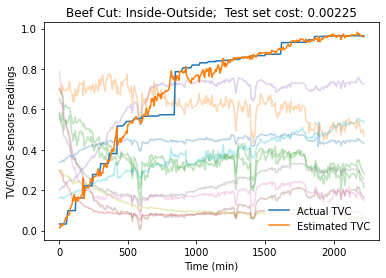

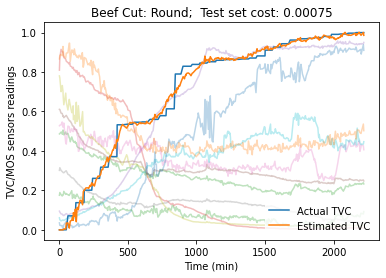

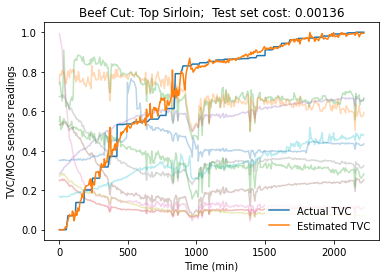

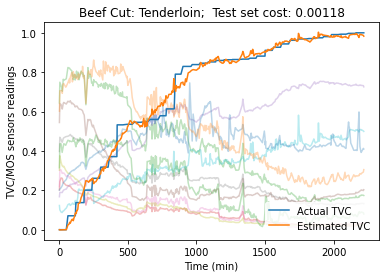

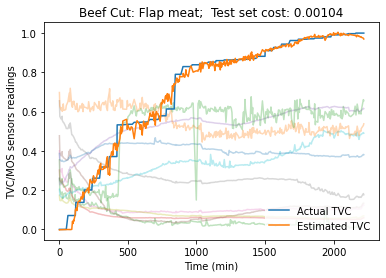

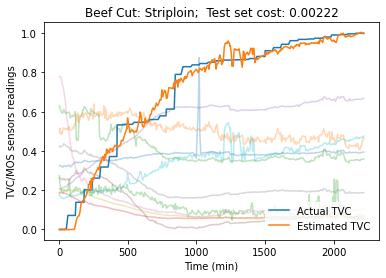

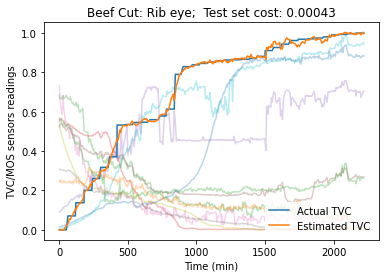

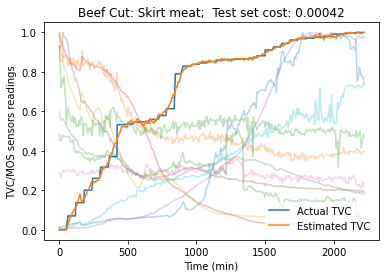

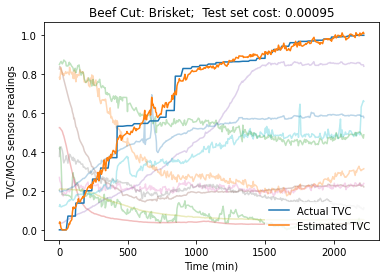

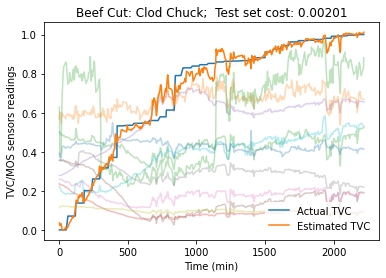

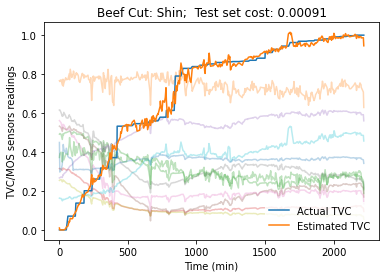

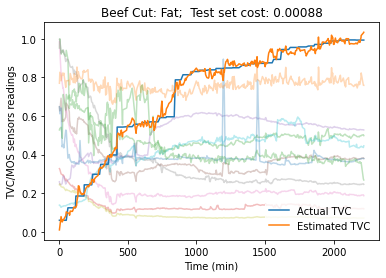

In [34]:
pred_TVC_TestS = np.empty_like(TVC_TestS)
pred_TVC = np.empty_like(TVC)

criterion = torch.nn.MSELoss(reduction='mean')

for i, cut in enumerate(cut_names):
    model[i].cpu()
    trained_models = [model_name for model_name in listdir('./{}'.format(cut)) if model_name[:2] == 'VL']
    validloss_models = [parse('VL{}', model_name)[0] for model_name in trained_models]
    best_model_vl = min(validloss_models)
    
    try:
        rmtree('./{}/best/'.format(cut))
    except(FileNotFoundError):
        pass
    copytree('./{}/VL{}/'.format(cut, best_model_vl), './{}/best/'.format(cut))
    
    model[i].load_state_dict(torch.load('./{}/best/model.pth'.format(cut)))
    
    with torch.no_grad():
        pred_TVC_TestS[:,i] = model[i](torch.tensor(sens_TestS[:,:,i], dtype=torch.float)).squeeze()
    
        plt.figure()
        
        plt.plot(t_TestS[:,i], TVC_TestS[:,i], label='Actual TVC', zorder=10)
        plt.plot(t_TestS[:,i], pred_TVC_TestS[:,i], label='Estimated TVC', zorder=11)

        plt.xlabel('Time (min)')
        plt.ylabel('TVC/MOS sensors readings')
        for j in range(11):
            plt.plot(t_TestS[:,i], sens_TestS[:,j,i], alpha=0.3, zorder=0)

        plt.legend(loc='lower right', frameon=True, framealpha=0.8, facecolor='w', edgecolor='w')

        plt.title('Beef Cut: {};  Test set cost: {:07.5f}'.format(cut, criterion(torch.tensor(pred_TVC_TestS[:,i]), torch.tensor(TVC_TestS[:,i])).numpy()))

        plt.savefig('./{}/best/regression-results.png'.format(cut), dpi=600)
        plt.savefig('./{}/best/regression-results.svg'.format(cut))

In the Scikit Learn package there are some functions contained in `sklearn.metrics` that allow the analysis of regression models. In this case, the MSE (best when it gets close to 0), the max error (best close to 0) and the [explained variance score](https://en.wikipedia.org/wiki/Explained_variation) (best possible score 1).

In [35]:
metrics.mean_squared_error(TVC_TestS, pred_TVC_TestS, multioutput='raw_values')

array([0.00225493, 0.0007515 , 0.00135672, 0.001176  , 0.001042  ,
       0.0022209 , 0.00043326, 0.00041842, 0.00095223, 0.00201492,
       0.00090557, 0.00087669])

In [36]:
np.array([metrics.max_error(TVC_TestS[:,i], pred_TVC_TestS[:,i]) for i in range(len(cut_names))])

array([0.21778963, 0.09673485, 0.19500064, 0.15364431, 0.13199896,
       0.13261099, 0.09560532, 0.09242136, 0.12143966, 0.18006169,
       0.15144921, 0.12468557])

In [37]:
metrics.explained_variance_score(TVC_TestS, pred_TVC_TestS, multioutput='raw_values')

array([0.97107864, 0.99141824, 0.98462858, 0.98664613, 0.98809284,
       0.97471815, 0.99505006, 0.99521975, 0.989281  , 0.97706601,
       0.98966659, 0.98845769])

## Classification performance

As it is contained in the original Excel workbook, the quality labels associated to each measure are dependent on the TVC range. Concretely, this relationship can be described as

\begin{equation}
    label=
    \begin{cases} 
      1 & TVC < 3 \\
      2 & 3 \leq TVC < 4 \\
      3 & 4 \leq TVC < 5 \\
      4 & 5 \leq TVC\\
    \end{cases} \quad .
\end{equation}

So, first, the TVC is denormalized and then, each predicted label is calculated.

In [38]:
denorm_pred_TVC_TestS = pred_TVC_TestS*(TVC_max - TVC_min) + TVC_min
denorm_TVC = TVC*(TVC_max - TVC_min) + TVC_min

In [39]:
pred_labels_TestS = np.empty_like(denorm_pred_TVC_TestS)

for i in range(len(cut_names)):
    for j in range(denorm_pred_TVC_TestS.shape[0]):
        if denorm_pred_TVC_TestS[j,i] < 3:
            pred_labels_TestS[j,i] = 1
        elif 3<= denorm_pred_TVC_TestS[j,i] <4:
            pred_labels_TestS[j,i] = 2
        elif 4<= denorm_pred_TVC_TestS[j,i] <5:
            pred_labels_TestS[j,i] = 3
        else:
            pred_labels_TestS[j,i] = 4

Now it's possible to treat this predicted labels as a classification problem outputs, so the classification popular metrics can be used:

- Confusion matrix
- Precision
- Recall
- F1-Score
- Accuracy

INSIDE-OUTSIDE




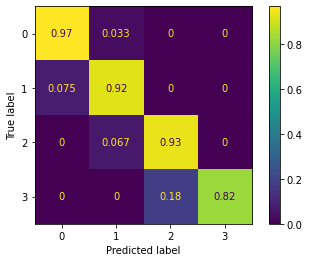



              precision    recall  f1-score   support

         1.0       0.94      0.97      0.95        60
         2.0       0.88      0.92      0.90        53
         3.0       0.60      0.93      0.73        75
         4.0       1.00      0.82      0.90       256

    accuracy                           0.87       444
   macro avg       0.85      0.91      0.87       444
weighted avg       0.91      0.87      0.88       444


----------------------------------



In [40]:
for i, cut in enumerate(cut_names[:1]):
    print(cut.upper())
    print('\n')
    cm = metrics.confusion_matrix(label_TestS[:,i], pred_labels_TestS[:,i], normalize='true')
    disp = metrics.ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()
    print('\n')
    print(metrics.classification_report(label_TestS[:,i], pred_labels_TestS[:,i]))
    print('\n----------------------------------\n')

You may noticed that each cut has an unbalanced dataset, since the meat spoilage process is not a linear phenomenon and the worst quality class includes all the TVC values from 5 and above. To get a complete performance description.

In [41]:
print('Balanced accuracy')
bal_acc = np.empty(len(cut_names))
for i, cut in  enumerate(cut_names):
    bal_acc[i] = metrics.balanced_accuracy_score(label_TestS[:,i], pred_labels_TestS[:,i])
    print('{:15}: {:.3}'.format(cut, bal_acc[i]))

print('\n\nAvg. balanced accuracy: {:.3}'.format(bal_acc.mean()))

Balanced accuracy
Inside-Outside : 0.911
Round          : 0.964
Top Sirloin    : 0.934
Tenderloin     : 0.964
Flap meat      : 0.946
Striploin      : 0.92
Rib eye        : 0.945
Skirt meat     : 0.933
Brisket        : 0.935
Clod Chuck     : 0.926
Shin           : 0.936
Fat            : 0.888


Avg. balanced accuracy: 0.933


## Appendix: Same model parameters and the dataset for the implementation

In [42]:
try:
    mkdir('TestSet')
except FileExistsError:
    pass

try:
    mkdir('TrainSet')
except FileExistsError:
    pass

try:
    mkdir('ValidSet')
except FileExistsError:
    pass

np.save('TestSet/t.npy', t_TestS)
np.save('TestSet/TVC.npy', TVC_TestS)
np.save('TestSet/pred_TVC.npy', pred_TVC_TestS)
np.save('TestSet/sens.npy', sens_TestS)

np.save('TrainSet/t.npy', t_TS)
np.save('TrainSet/TVC.npy', TVC_TS.cpu())
np.save('TrainSet/sens.npy', sens_TS.cpu())

np.save('ValidSet/t.npy', t_CrossVS)
np.save('ValidSet/TVC.npy', TVC_CrossVS.cpu())
np.save('ValidSet/sens.npy', sens_CrossVS.cpu())

In [43]:
np.save('TVC_min.npy', TVC_min)
np.save('TVC_max.npy', TVC_max)